# Spike count statistics

## Simulated transition

In [1]:
from imp import reload
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams
import sys, os
import time
sys.path.append(os.path.abspath('../presentation')) # include path with style
sys.path.append(os.path.abspath('../simulation/')) # include path with simulation specifications
import pres_style as style; reload(style)

# Import specific moduls
#import network_params; reload(network_params)
import model_class; reload(model_class)
import sim_params as sim; reload(sim)
%matplotlib inline

show_fig = False
save_fig = True
picture_format = ".pdf"
xfactor = 2.6
style.rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83) 
figure_path = os.path.join(".", "figures")

reverse_order = True # do analysis such that plots resemble those of the paper (starting with L6i)
plotting = True

In [2]:
# DATA
data_file = "micro"
data_sup_path = "/export/data-schuessler/data_microcircuit/"
data_path = os.path.join(data_sup_path, data_file)
sim_spec = "a1.0_t300.2_totalN_00"

# Original data
file_name  = sim_spec + ".hdf5"  
res_file_name = sim_spec + "_res.hdf5"

### Basic data

In [3]:
# Open file: data
data_file = h5py.File(os.path.join(data_path, file_name), "r")

# Simulation attributes
area    = data_file.attrs["area"]   
t_sim   = data_file.attrs["t_sim"]  
t_trans = data_file.attrs["t_trans"]
dt      = data_file.attrs["dt"]    
populations   = data_file.attrs["populations"].astype("|U4")
layers        = data_file.attrs["layers"].astype("|U4")        
types         = data_file.attrs["types"].astype("|U4")     
n_populations = data_file.attrs["n_populations"]
n_layers      = data_file.attrs["n_layers"]       
n_types       = data_file.attrs["n_types"] 

t_measure = t_sim - t_trans


# labels & colors: need to be adapted if n_types != (e, i)
layer_colors = style.colors[:n_layers]
colors = np.array([color for color in layer_colors for i in range(n_types)])
colors[1::2] = colors[1::2] * 0.4   #### adapt for more than two types!
if reverse_order:
    populations = populations[::-1]
    layers = layers[::-1]
    types = types[::-1]
    colors = colors[::-1]
data_file.close()

### Raster plot

0


/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


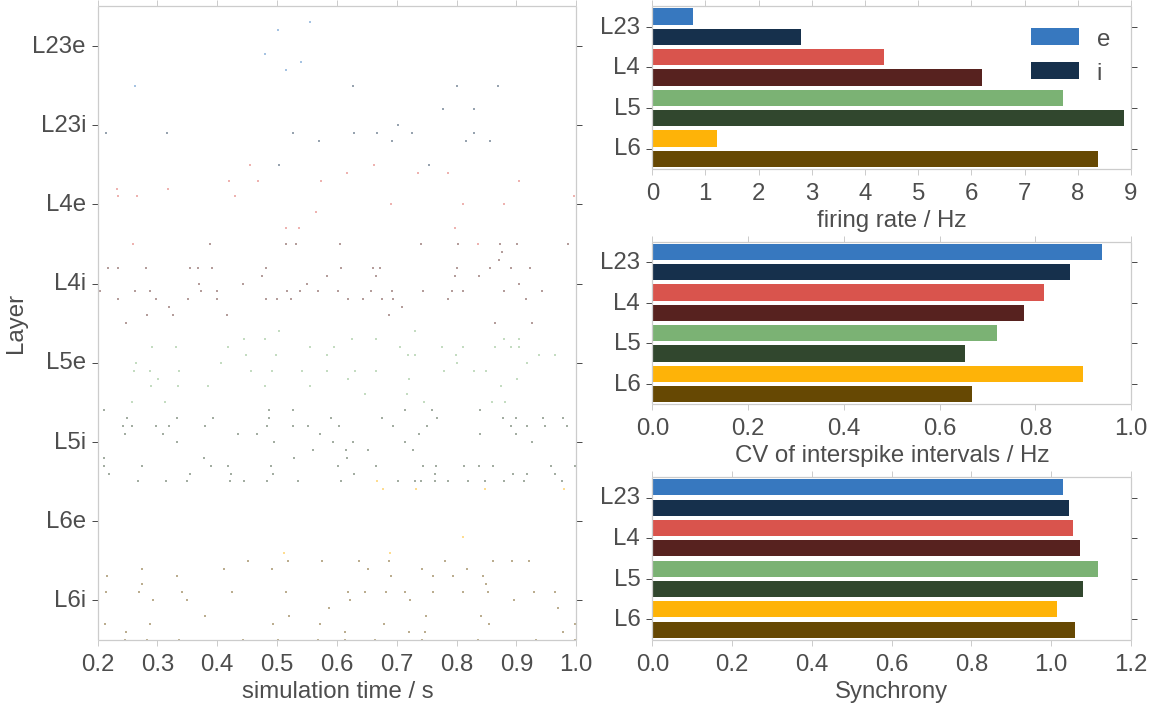

In [4]:
sim_spec2 = "0"
print(sim_spec2)
# Data
with h5py.File(os.path.join(data_path, res_file_name), "r") as res_file:
    res_grp = res_file[sim_spec2]
    res_raster = res_grp["raster"]

    rates_mean   = res_grp["rates_mean"][:]
    rates_std    = res_grp["rates_std"]
    cv_isi_mean  = res_grp["cv_isi_mean"]
    cv_isi_std   = res_grp["cv_isi_std"]
    synchrony    = res_grp["synchrony"]

    t_min_raster = res_raster.attrs["t_min_raster"]
    t_max_raster = res_raster.attrs["t_max_raster"]
    ymax_raster = res_raster.attrs["ymax_raster"]
    yticks = res_raster.attrs["yticks"]


fig = plt.figure()

# Raster plot
ax0 = plt.subplot2grid((3, 2), (0, 0), colspan=1, rowspan=3)
# Rates
ax1 = plt.subplot2grid((3, 2), (0, 1), colspan=1, rowspan=1)
# CV of interspike interval (ISI)
ax2 = plt.subplot2grid((3, 2), (1, 1), colspan=1, rowspan=1)
# Synchrony
ax3 = plt.subplot2grid((3, 2), (2, 1), colspan=1, rowspan=1)    

y_mean = np.arange(n_populations) + 0.1
bar_height = 0.8 
for i, population in enumerate(populations):
    res_raster_pop = res_raster[str(population)]
    for times, neuron_ids in res_raster_pop.values():
        ax0.plot(times, neuron_ids, '.', ms=3, color=colors[i], label=population)
    ax1.barh(y_mean[i], rates_mean[i], height=bar_height, color=colors[i], linewidth=0)
    ax2.barh(y_mean[i], cv_isi_mean[i], height=bar_height, color=colors[i], linewidth=0)
    ax3.barh(y_mean[i], synchrony[i],   height=bar_height, color=colors[i], linewidth=0)    


# Raster Plot
xlim = (t_min_raster, t_max_raster)
ylim = (0, ymax_raster)
ax0.set_yticks(yticks)
ax0.set_yticklabels(populations)
ax0.set_xlabel('simulation time / s')
ax0.set_ylabel('Layer')
ax0.set_xlim(*xlim)
ax0.set_ylim(*ylim)
ax0.grid(False)

# Rates
ax1.set_xlabel('firing rate / Hz')
# CV of ISI
ax2.set_xlabel('CV of interspike intervals / Hz')
# Synchrony
ax3.set_xlabel('Synchrony')

ylim_mean = (0, n_populations)
yticks_mean = np.arange(n_types * 0.5, n_populations, n_types)
for ax in (ax1, ax2, ax3):
    #ax.set_ylabel('Layer')
    ax.set_yticks(yticks_mean)
    ax.set_yticklabels(layers)
    ax.set_ylim(*ylim_mean)
    ax.grid(False)

# Legend; order is reversed, such that labels appear correctly
for i in range(n_types):
    ax1.barh(0, 0, 0, color=colors[-(i+1)], label=types[-(i+1)], linewidth=0)
ax1.legend(loc='best')

for ax in fig.axes:
    style.fixticks(ax)
fig_name = "cell_activity_" + sim_spec + "_" + sim_spec2

if save_fig:
    fig.savefig(os.path.join(figure_path,fig_name + picture_format))
else:

    suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
    suptitle += '\nfile: ' + os.path.join(sim_spec, sim_spec2)
    fig.suptitle(suptitle, y=0.98)


## Spike count statistics

In [6]:
n_bins         = 300
bins           = np.arange(0, n_bins)
hist_n_spikes = np.zeros((n_populations, n_bins))

data_file = h5py.File(os.path.join(data_path, file_name), "r")
grp = data_file[sim_spec2 + "/spikes"]

for i, population in enumerate(populations):
    subgrp = grp[str(population)]
    raw_times_all   = subgrp["times"][:] * dt * 1e-3 # in seconds
    indices         = subgrp["rec_neuron_i"][:]

    n_spikes_total = np.zeros(len(indices) - 1)
    for j in range(len(indices) - 1):
        times = raw_times_all[indices[j]:indices[j+1]]
        times = times[times > t_trans]      
        n_spikes_total[j] = len(times)

    hist_n_spikes[i] = np.histogram(n_spikes_total, bins=n_bins, 
                                     range=(0, n_bins), density=False)[0]

data_file.close()

<n>	var[n]	fano
2513.48	-6267804.04	-2493.68
365.45	-114251.56	-312.63
save figure to isi_histo_a1.0_t300.2_totalN_00_7.pdf
2662.99	-7025466.74	-2638.19
2317.37	-5331817.72	-2300.81
save figure to isi_histo_a1.0_t300.2_totalN_00_7.pdf
1860.21	-3400992.49	-1828.28
1308.37	-1666126.56	-1273.44
save figure to isi_histo_a1.0_t300.2_totalN_00_7.pdf
840.04	-657324.44	-782.49
231.13	-32455.82	-140.42
save figure to isi_histo_a1.0_t300.2_totalN_00_7.pdf


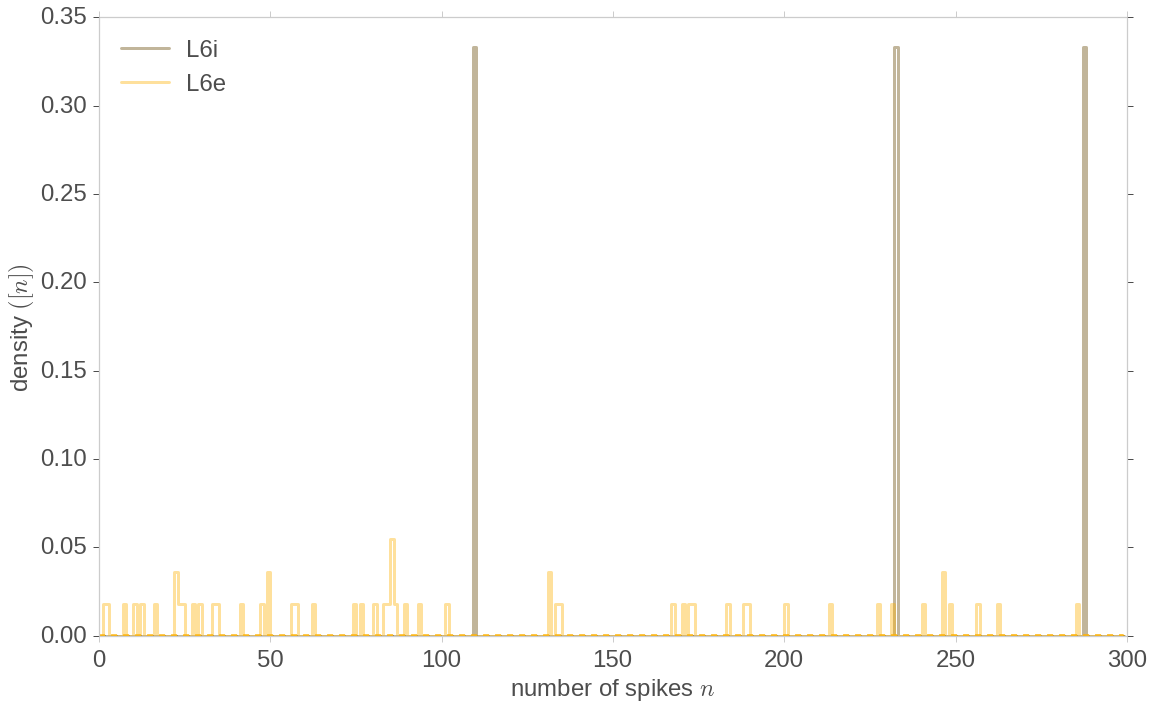

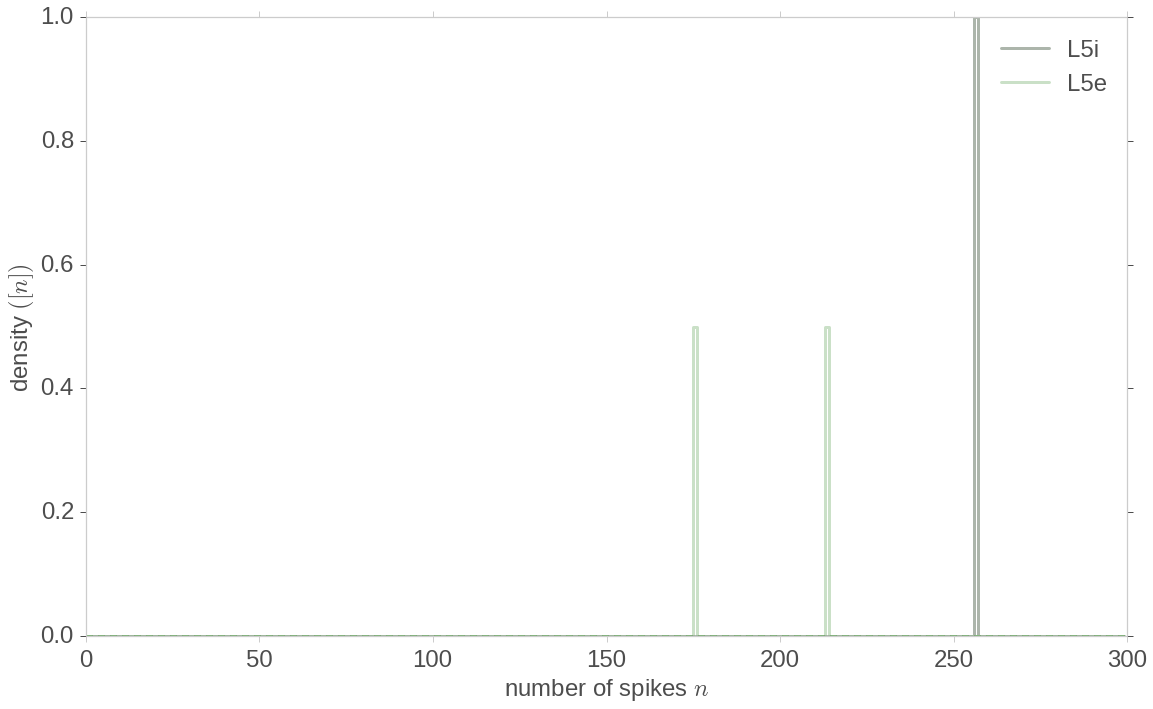

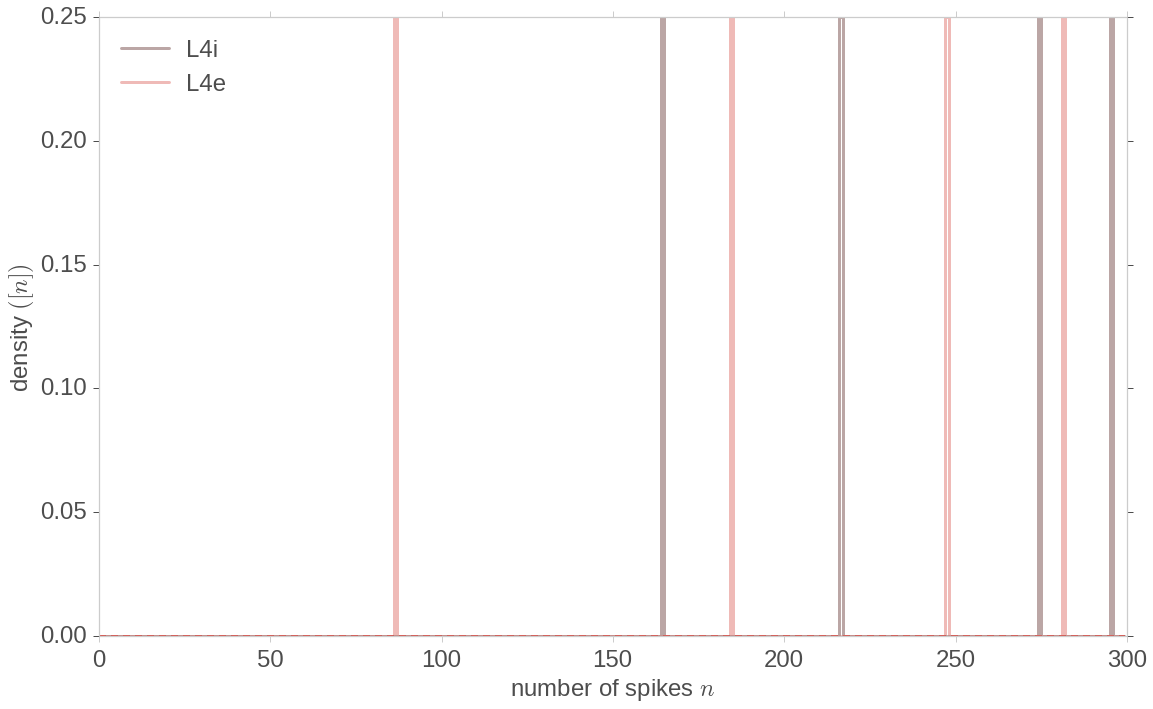

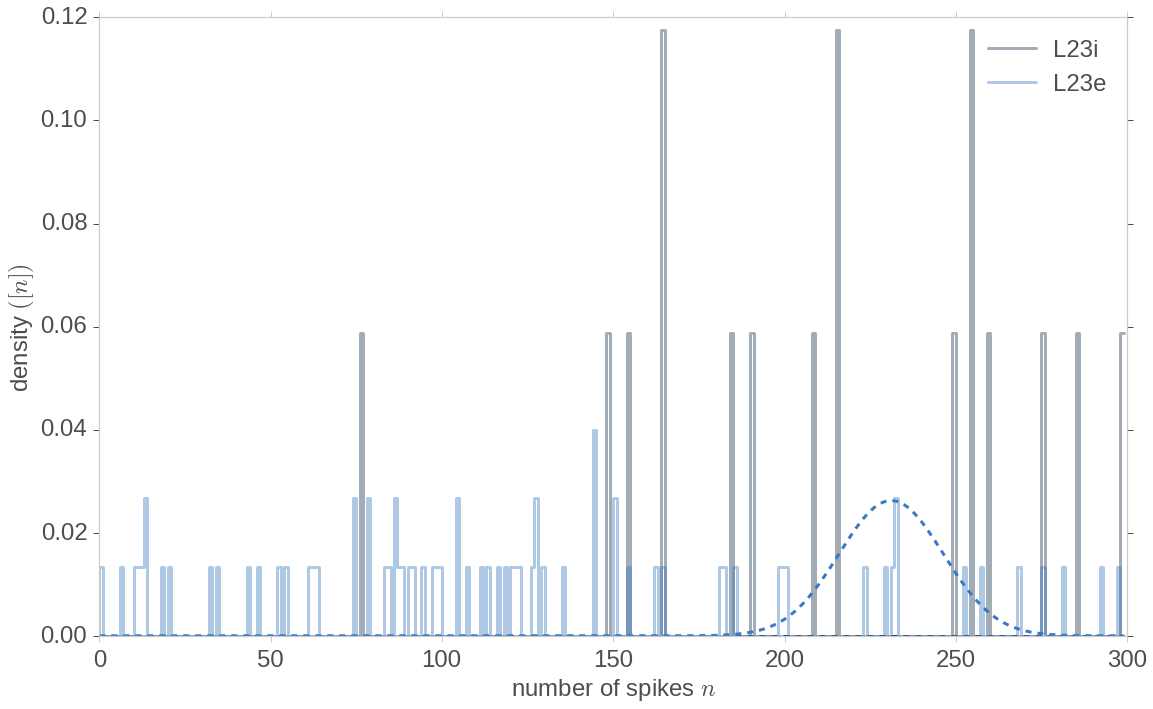

In [25]:
# Theory: P_T[n] = (r * T)**(n) / n! * exp(-r * T)
def P_n_spikes(n, rate, T=t_measure):
    from scipy.misc import factorial
    return (rate * T)**n / factorial(n) * np.exp(-rate * T)
def gauss(n, rate, T=t_measure):
    mu = rate * T
    sigma = np.sqrt(mu)
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp(- (n - mu)**2 / (2 * sigma**2))


print("<n>\tvar[n]\tfano")
for l, layer in enumerate(layers):
    fig = plt.figure()

    gridspec=plt.GridSpec(1, 1)
    subplotspec=gridspec.new_subplotspec((0, 0), rowspan=1, colspan=1)
    ax = fig.add_subplot(subplotspec)

    x_max = 0
    for i, population in enumerate(populations):
        if population.startswith(layer):
            rate = rates_mean[i]
            ax.plot(bins, hist_n_spikes[i] / np.sum(hist_n_spikes[i]), 
                     linewidth=3., color=colors[i], alpha=0.4, drawstyle="steps", label=population)
            ax.plot(bins, gauss(bins, rate), "--",
                     linewidth=3., color=colors[i], alpha=0.99)
            mean = rate * t_measure
            var = np.dot(hist_n_spikes[i], bins ** 2) / np.sum(hist_n_spikes[i]) - mean**2
            fano_factor = var / mean
            print("{0:6.2f}\t{1:6.2f}\t{2:6.2f}".format(rate * t_measure, var, fano_factor))
        
            # calc the upper xlim
            new_x_max = mean + 2 * np.sqrt(mean)
            if new_x_max > x_max:
                x_max = new_x_max
            
    #ax.set_xlim(0, x_max)
    ax.set_ylabel('density $([n])$')
    ax.set_xlabel('number of spikes $n$')
    ax.legend(loc="best")
    ax.grid(False)
    style.fixticks(ax)

    fig_name = "isi_histo_" + sim_spec

    fig_name += "_" + str(i)
    fig_name += picture_format

    if save_fig:
        print("save figure to " + fig_name)
        fig.savefig(os.path.join(figure_path,fig_name))
    else:
        suptitle = 'Simulation for: area = %.1f, time = %ims'%(area, t_sim)
        suptitle += '\nfile: ' + sim_spec
        fig.suptitle(suptitle, y=0.98)

    if show_fig:
        fig.show()